# Wikipedia Kaggle Data Peak

In [1]:
import pandas as pd
import numpy as np
import gensim
import spacy
import nltk
import json
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import pyLDAvis as pyldavis
import pyLDAvis.sklearn

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Read dataset given by Kaggle of Wikipedia articles.

In [2]:
import sqlite3
conn = sqlite3.connect('../data/wiki-kaggle-17_18.db')
crsr = conn.cursor()

Peak into the tables.

In [3]:
query = """
        SELECT 
            ARTICLE_ID,
            REPLACE(GROUP_CONCAT(SECTION_TEXT, ' '), '\n', ' ') AS CONTENT 
        FROM ARTICLES 
        GROUP BY ARTICLE_ID
        """

for chunk in pd.read_sql_query(query, conn, chunksize=50000):
    df = chunk
    break

In [4]:
raw_data = []
clean_data = []

def valid(txt):
    if txt is None: return
    if txt in ENGLISH_STOP_WORDS: return
    if len(txt) <= 3: return
    return True

for idx, row in df.iterrows():
    raw_data += [row["CONTENT"]]
    clean_text = re.sub("[^a-zA-Z]+", " ", row["CONTENT"])
    clean_text = clean_text.lower()
    split_text = [t for t in clean_text.split(" ") if valid(t)]
    clean_data += [" ".join(split_text)]

In [5]:
pd.DataFrame(clean_data)

,0
0,anarchism political philosophy advocates self ...
1,autism neurodevelopmental disorder characteriz...
2,percentage diffusely reflected sunlight relati...
3,writing cursive forms named plural letter vowe...
4,alabama state southeastern region united state...
5,achilles nereid cymothoe attic figure kantharo...
6,abraham lincoln february april american politi...
7,aristotle aristot ancient greek philosopher sc...
8,american paris jazz influenced orchestral piec...
9,academy award best production design recognize...


In [6]:
word_ids = []
vocab = {}
for row in clean_data:
    bag = {}
    row = row.split(" ")
    row = [word for word in row if word]
    for word in row:
        if word in vocab:vocab[word] += 1
        else: 
            word_ids += [word]
            vocab[word] = 1
    
freq_bag = []
for word in vocab.keys():
    freq_bag += [{ "text": word, "count": vocab[word] }]

In [7]:
freq_df = pd.DataFrame(freq_bag)
sorted_freq = freq_df.sort_values("count")
counts = []
labels = []
for cnt in sorted_freq.values:
    counts += [cnt[0]]
    labels += ["{}, {}".format(cnt[1], cnt[0])]

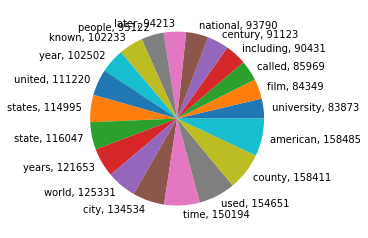

In [8]:
plt.pie(counts[-20:], labels=labels[-20:])
plt.show()

In [9]:
no_topics = 20
no_top_words = 10

In [10]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_label = "Topic {}".format(topic_idx)
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics += [[*words]]
    return topics

In [11]:
def eval_model(best=None, model=None, vect=None, use_simple=False):
    print("= SUMMARY", "="*50, "\n")
    if best:
        best_model = best.best_estimator_
        print("Params:\t{}".format(best.best_params_))
        print("Log Likelihood:\t{}".format(best.best_score_))
        print("Perplexity:\t{}".format(best_model.perplexity(vect)))
        return

    data_dense = vect.todense()
    print("Sparsicity:\t{} %".format(((data_dense > 0).sum()/data_dense.size)*100))
    if not use_simple:
        print("Log Likelihood:\t{}".format(model.score(vect)))
        print("Perplexity:\t{}".format(model.perplexity(vect)))
    print(json.dumps(model.get_params(), indent=2))

In [12]:
vect = CountVectorizer(ngram_range=(1,1), stop_words="english")
cnt = vect.fit_transform(clean_data)
cnt_feature_names = vect.get_feature_names()

In [13]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_model = lda.fit(cnt)

In [14]:
lda_topics = display_topics(lda_model, cnt_feature_names, no_top_words)
pd.DataFrame(lda_topics)

,0,1,2,3,4,5,6,7,8,9
0,species,genus,color,till,family,text,birds,tree,group,animals
1,open,champion,frankfurt,hamburg,andorra,lama,quarterfinalist,dalai,hesse,culebra
2,water,used,food,large,known,small,island,species,plant,called
3,king,century,church,roman,death,time,later,great,known,john
4,court,dutch,rights,legal,states,case,justice,netherlands,state,courts
5,music,album,band,song,rock,musical,songs,sound,opera,recorded
6,series,game,story,character,novel,games,characters,fiction,stories,star
7,government,united,states,party,president,national,state,military,british,general
8,language,used,languages,english,word,words,example,form,latin,meaning
9,university,work,theory,science,published,book,school,society,research,press


In [15]:
search_params = {
    "n_components": range(10, 50, 5),
    "learning_decay": [.5, .7, .9]
    }

tunedlda = LatentDirichletAllocation()
tunedlda_model = GridSearchCV(tunedlda, param_grid=search_params, cv=3)
tunedlda_model.fit(cnt)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': range(10, 50, 5), 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
best_lda_model = tunedlda_model.best_estimator_

In [18]:
pyldavis.enable_notebook()

In [65]:
panel = pyldavis.sklearn.prepare(best_lda_model, cnt, vect, mds="tsne")

/home/alphamamer/git/wikiextract/py_modules/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [66]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9       48.923634  242.245270       1        1  16.768522
7      181.610214 -218.717911       2        1  12.969676
5     -127.508339 -122.331161       3        1  12.305409
0     -145.438675  200.972626       4        1  11.520447
1     -232.971817   22.588764       5        1  10.599288
4      -12.754887 -260.012482       6        1   8.385463
3      -32.404358   55.860909       7        1   8.290571
8      163.594193  104.518051       8        1   7.335011
6      269.121735  -40.332485       9        1   5.921514
2       68.516190  -73.652832      10        1   5.904097, topic_info=       Category           Freq        Term          Total  loglift  logprob
169311  Default  155096.000000      county  155096.000000  30.0000  30.0000
149269  Default  132410.000000        city  132410.000000  29.0000  29.0000
262126  Default   83372.000000        film   83372.000000  28.0000  28.0000
281840  Default   46291.000000        game   46291.000000  27.0000  27.0000
615270  Default   73848.000000  population   73848.000000  26.0000  26.0000
26298   Default  156338.000000    american  156338.000000  25.0000  25.0000
740398  Default  114213.000000       state  114213.000000  24.0000  24.0000
406875  Default   65053.000000        king   65053.000000  23.0000  23.0000
821356  Default  152055.000000        used  152055.000000  22.0000  22.0000
692374  Default   64759.000000      school   64759.000000  21.0000  21.0000
770494  Default   36690.000000        team   36690.000000  20.0000  20.0000
42162   Default   72482.000000        area   72482.000000  19.0000  19.0000
696392  Default   34530.000000      season   34530.000000  18.0000  18.0000
281955  Default   29619.000000       games   29619.000000  17.0000  17.0000
303490  Default   77261.000000  government   77261.000000  16.0000  16.0000
521797  Default   53768.000000       music   53768.000000  15.0000  15.0000
664508  Default   50504.000000       river   50504.000000  14.0000  14.0000
731293  Default   79836.000000       south   79836.000000  13.0000  13.0000
131381  Default   29669.000000      census   29669.000000  12.0000  12.0000
131946  Default   90246.000000     century   90246.000000  11.0000  11.0000
607913  Default   38466.000000      player   38466.000000  10.0000  10.0000
668036  Default   38786.000000       roman   38786.000000   9.0000   9.0000
435886  Default   29705.000000      league   29705.000000   8.0000   8.0000
548636  Default   76168.000000       north   76168.000000   7.0000   7.0000
44501   Default   44343.000000        army   44343.000000   6.0000   6.0000
360698  Default   28486.000000      income   28486.000000   5.0000   5.0000
621935  Default   50842.000000   president   50842.000000   4.0000   4.0000
485634  Default   21947.000000      median   21947.000000   3.0000   3.0000
18697   Default   31326.000000       album   31326.000000   2.0000   2.0000
499345  Default   44979.000000    military   44979.000000   1.0000   1.0000
...         ...            ...         ...            ...      ...      ...
478654  Topic10    5788.869533       match    8366.190345   2.4613  -6.4390
694539  Topic10    2136.839010     scoring    2554.049063   2.6512  -7.4356
561698  Topic10    5274.549747     olympic    7609.153377   2.4631  -6.5320
64237   Topic10    5982.037563        ball    8945.004380   2.4272  -6.4062
753973  Topic10    6731.464922       super   10335.734765   2.4007  -6.2881
614940  Topic10    8918.484238        pope   14727.366101   2.3279  -6.0068
269108  Topic10   11815.304684    football   21229.962939   2.2435  -5.7255
139811  Topic10    3218.593955       chess    4265.820660   2.5478  -7.0260
857646  Topic10    2805.748190        wins    3613.321612   2.5766  -7.1633
218418  Topic10    8039.456079        duke   14302.115009   2.2535  -6.1106
607913  Topic10   15931.490864      player   38466.030823   1.9480  -

In [67]:
panel = pyldavis.sklearn.prepare(best_lda_model, cnt, vect, mds="mmds")

/home/alphamamer/git/wikiextract/py_modules/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [68]:
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.199138  0.099066       1        1  16.768522
7     -0.087040 -0.071456       2        1  12.969676
5      0.039630  0.231484       3        1  12.305409
0     -0.032113 -0.279406       4        1  11.520447
1      0.105059  0.067639       5        1  10.599288
4      0.252852  0.161444       6        1   8.385463
3      0.141618 -0.089570       7        1   8.290571
8     -0.261085 -0.080885       8        1   7.335011
6      0.173757 -0.269260       9        1   5.921514
2     -0.133539  0.230944      10        1   5.904097, topic_info=       Category           Freq        Term          Total  loglift  logprob
169311  Default  155096.000000      county  155096.000000  30.0000  30.0000
149269  Default  132410.000000        city  132410.000000  29.0000  29.0000
262126  Default   83372.000000        film   83372.000000  28.0000  28.0000
281840  Default   46291.000000        game   46291.000000  27.0000  27.0000
615270  Default   73848.000000  population   73848.000000  26.0000  26.0000
26298   Default  156338.000000    american  156338.000000  25.0000  25.0000
740398  Default  114213.000000       state  114213.000000  24.0000  24.0000
406875  Default   65053.000000        king   65053.000000  23.0000  23.0000
821356  Default  152055.000000        used  152055.000000  22.0000  22.0000
692374  Default   64759.000000      school   64759.000000  21.0000  21.0000
770494  Default   36690.000000        team   36690.000000  20.0000  20.0000
42162   Default   72482.000000        area   72482.000000  19.0000  19.0000
696392  Default   34530.000000      season   34530.000000  18.0000  18.0000
281955  Default   29619.000000       games   29619.000000  17.0000  17.0000
303490  Default   77261.000000  government   77261.000000  16.0000  16.0000
521797  Default   53768.000000       music   53768.000000  15.0000  15.0000
664508  Default   50504.000000       river   50504.000000  14.0000  14.0000
731293  Default   79836.000000       south   79836.000000  13.0000  13.0000
131381  Default   29669.000000      census   29669.000000  12.0000  12.0000
131946  Default   90246.000000     century   90246.000000  11.0000  11.0000
607913  Default   38466.000000      player   38466.000000  10.0000  10.0000
668036  Default   38786.000000       roman   38786.000000   9.0000   9.0000
435886  Default   29705.000000      league   29705.000000   8.0000   8.0000
548636  Default   76168.000000       north   76168.000000   7.0000   7.0000
44501   Default   44343.000000        army   44343.000000   6.0000   6.0000
360698  Default   28486.000000      income   28486.000000   5.0000   5.0000
621935  Default   50842.000000   president   50842.000000   4.0000   4.0000
485634  Default   21947.000000      median   21947.000000   3.0000   3.0000
18697   Default   31326.000000       album   31326.000000   2.0000   2.0000
499345  Default   44979.000000    military   44979.000000   1.0000   1.0000
...         ...            ...         ...            ...      ...      ...
478654  Topic10    5788.869533       match    8366.190345   2.4613  -6.4390
694539  Topic10    2136.839010     scoring    2554.049063   2.6512  -7.4356
561698  Topic10    5274.549747     olympic    7609.153377   2.4631  -6.5320
64237   Topic10    5982.037563        ball    8945.004380   2.4272  -6.4062
753973  Topic10    6731.464922       super   10335.734765   2.4007  -6.2881
614940  Topic10    8918.484238        pope   14727.366101   2.3279  -6.0068
269108  Topic10   11815.304684    football   21229.962939   2.2435  -5.7255
139811  Topic10    3218.593955       chess    4265.820660   2.5478  -7.0260
857646  Topic10    2805.748190        wins    3613.321612   2.5766  -7.1633
218418  Topic10    8039.456079        duke   14302.115009   2.2535  -6.1106
607913  Topic10   15931.490864      player   38466.030823   1.9480  -5.4266
406875  Topic10   22693.254854        kin

In [22]:
clusters = KMeans(n_clusters=10, random_state=100)
clusters = clusters.fit_predict(cnt)

In [23]:
svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(cnt)

In [24]:
x = lda_output_svd[:,0]
y = lda_output_svd[:,1]

In [25]:
print("Weights: {}".format(np.round(svd_model.components_, 2)))

Weights: [[ 0.  0.  0. ...  0.  0.  0.]
 [-0. -0. -0. ...  0. -0. -0.]]


In [26]:
print("% of Variance Explained: {}".format(np.round(svd_model.explained_variance_ratio_, 2)))

% of Variance Explained: [0.04 0.02]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

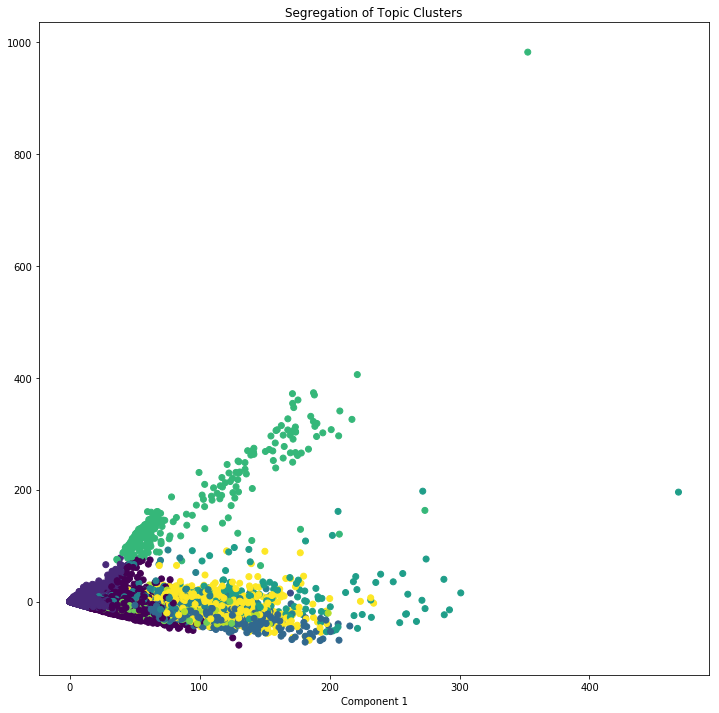

In [27]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel("Component 2")
plt.xlabel("Component 1")
plt.title("Segregation of Topic Clusters")

### Topic Prediction

We will be using the famous _I have a dream speech_ as delivered by _Martin Luther King Jr._.

In [69]:
from IPython.display import Markdown

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}')

def sent_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))
        
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for sent in texts:
        doc = nlp(" ". join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ["-PRON-"] else "" for token in doc if token.pos_ in allowed_postags]))
    return texts_out

def predict_topic(text, model=None, nlp=nlp):
    if not model: return None, None
    processed = list(sent_to_words(text))
    lemmatized = lemmatization(processed, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"])
    vectorizer.fit(lemmatized)
    vectorized = vectorizer.transform(lemmatized)
    df_topic_keywords = pd.DataFrame(model.components_)
    vectorized._shape = (len(text), df_topic_keywords.shape[1])
    topic_prob_scores = model.transform(vectorized)
    topic = df_topic_keywords.iloc[np.argmax(topic_prob_scores), :].values.tolist()
    return topic, topic_prob_scores

def similar_documents(text, doc_topic_probs, documents, nlp=nlp, top_n=5, verbose=False, model=None):
    topic, x = predict_topic(text, model)
    dists = euclidean_distances(x.reshape(len(text), -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:
        print("Topic key words: {}".format(topic))
        print("Topic prob scores of text: {}".format(np.round(x, 1)))
        print("Most similar doc's probs: {}".format(np.round(doc_topic_probs[doc_ids], 1)))
    return doc_ids, np.take(documents, doc_ids)

def display_article(text):
    clean_md = text.replace(' ===', '\n\n### ')
    clean_md = clean_md.replace('=== ', '\n\n')
    clean_md = clean_md.replace("'''", '_')
    return Markdown(clean_md)

In [70]:
test_text = ["""
I am happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation.
Five score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice. It came as a joyous daybreak to end the long night of their captivity.
But one hundred years later, the Negro still is not free. One hundred years later, the life of the Negro is still sadly crippled by the manacles of segregation and the chains of discrimination. One hundred years later, the Negro lives on a lonely island of poverty in the midst of a vast ocean of material prosperity. One hundred years later, the Negro is still languishing in the corners of American society and finds himself an exile in his own land. So we have come here today to dramatize a shameful condition.
In a sense we have come to our nation’s capital to cash a check. When the architects of our republic wrote the magnificent words of the Constitution and the Declaration of Independence, they were signing a promissory note to which every American was to fall heir. This note was a promise that all men, yes, black men as well as white men, would be guaranteed the unalienable rights of life, liberty, and the pursuit of happiness.
It is obvious today that America has defaulted on this promissory note insofar as her citizens of color are concerned. Instead of honoring this sacred obligation, America has given the Negro people a bad check, a check which has come back marked “insufficient funds.” But we refuse to believe that the bank of justice is bankrupt. We refuse to believe that there are insufficient funds in the great vaults of opportunity of this nation. So we have come to cash this check — a check that will give us upon demand the riches of freedom and the security of justice. We have also come to this hallowed spot to remind America of the fierce urgency of now. This is no time to engage in the luxury of cooling off or to take the tranquilizing drug of gradualism. Now is the time to make real the promises of democracy. Now is the time to rise from the dark and desolate valley of segregation to the sunlit path of racial justice. Now is the time to lift our nation from the quick sands of racial injustice to the solid rock of brotherhood. Now is the time to make justice a reality for all of God’s children.
It would be fatal for the nation to overlook the urgency of the moment. This sweltering summer of the Negro’s legitimate discontent will not pass until there is an invigorating autumn of freedom and equality. Nineteen sixty-three is not an end, but a beginning. Those who hope that the Negro needed to blow off steam and will now be content will have a rude awakening if the nation returns to business as usual. There will be neither rest nor tranquility in America until the Negro is granted his citizenship rights. The whirlwinds of revolt will continue to shake the foundations of our nation until the bright day of justice emerges.
But there is something that I must say to my people who stand on the warm threshold which leads into the palace of justice. In the process of gaining our rightful place we must not be guilty of wrongful deeds. Let us not seek to satisfy our thirst for freedom by drinking from the cup of bitterness and hatred.
We must forever conduct our struggle on the high plane of dignity and discipline. We must not allow our creative protest to degenerate into physical violence. Again and again we must rise to the majestic heights of meeting physical force with soul force. The marvelous new militancy which has engulfed the Negro community must not lead us to a distrust of all white people, for many of our white brothers, as evidenced by their presence here today, have come to realize that their destiny is tied up with our destiny. They have come to realize that their freedom is inextricably bound to our freedom. We cannot walk alone.
As we walk, we must make the pledge that we shall always march ahead. We cannot turn back. There are those who are asking the devotees of civil rights, “When will you be satisfied?” We can never be satisfied as long as the Negro is the victim of the unspeakable horrors of police brutality. We can never be satisfied, as long as our bodies, heavy with the fatigue of travel, cannot gain lodging in the motels of the highways and the hotels of the cities. We cannot be satisfied as long as the Negro’s basic mobility is from a smaller ghetto to a larger one. We can never be satisfied as long as our children are stripped of their selfhood and robbed of their dignity by signs stating “For Whites Only”. We cannot be satisfied as long as a Negro in Mississippi cannot vote and a Negro in New York believes he has nothing for which to vote. No, no, we are not satisfied, and we will not be satisfied until justice rolls down like waters and righteousness like a mighty stream.
I am not unmindful that some of you have come here out of great trials and tribulations. Some of you have come fresh from narrow jail cells. Some of you have come from areas where your quest for freedom left you battered by the storms of persecution and staggered by the winds of police brutality. You have been the veterans of creative suffering. Continue to work with the faith that unearned suffering is redemptive.
Go back to Mississippi, go back to Alabama, go back to South Carolina, go back to Georgia, go back to Louisiana, go back to the slums and ghettos of our northern cities, knowing that somehow this situation can and will be changed. Let us not wallow in the valley of despair.
I say to you today, my friends, so even though we face the difficulties of today and tomorrow, I still have a dream. It is a dream deeply rooted in the American dream.
I have a dream that one day this nation will rise up and live out the true meaning of its creed: “We hold these truths to be self-evident: that all men are created equal.”
I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood.
I have a dream that one day even the state of Mississippi, a state sweltering with the heat of injustice, sweltering with the heat of oppression, will be transformed into an oasis of freedom and justice.
I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.
I have a dream today.
I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama, little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers.
I have a dream today.
I have a dream that one day every valley shall be exalted, every hill and mountain shall be made low, the rough places will be made plain, and the crooked places will be made straight, and the glory of the Lord shall be revealed, and all flesh shall see it together.
This is our hope. This is the faith that I go back to the South with. With this faith we will be able to hew out of the mountain of despair a stone of hope. With this faith we will be able to transform the jangling discords of our nation into a beautiful symphony of brotherhood. With this faith we will be able to work together, to pray together, to struggle together, to go to jail together, to stand up for freedom together, knowing that we will be free one day.
This will be the day when all of God’s children will be able to sing with a new meaning, “My country, ‘tis of thee, sweet land of liberty, of thee I sing. Land where my fathers died, land of the pilgrim’s pride, from every mountainside, let freedom ring.”
And if America is to be a great nation this must become true. So let freedom ring from the prodigious hilltops of New Hampshire. Let freedom ring from the mighty mountains of New York. Let freedom ring from the heightening Alleghenies of Pennsylvania!
Let freedom ring from the snowcapped Rockies of Colorado!
Let freedom ring from the curvaceous slopes of California!
But not only that; let freedom ring from Stone Mountain of Georgia!
Let freedom ring from Lookout Mountain of Tennessee!
Let freedom ring from every hill and molehill of Mississippi. From every mountainside, let freedom ring.
And when this happens, when we allow freedom to ring, when we let it ring from every village and every hamlet, from every state and every city, we will be able to speed up that day when all of God’s children, black men and white men, Jews and Gentiles, Protestants and Catholics, will be able to join hands and sing in the words of the old Negro spiritual, “Free at last! free at last! thank God Almighty, we are free at last!”
"""]

In [71]:
lda_output = best_lda_model.transform(cnt)
doc_ids, test_text_docs = similar_documents(test_text, lda_output, raw_data, top_n=1, verbose=False, model=best_lda_model)

In [72]:
display_article(test_text_docs[0])

_ATP_ may refer to:    * Available-to-promise, a business function that provides a response to customer order enquiries  * Association of Tennis Professionals, international men's professional tennis association * American Technical Publishers, an employee-owned publishing company located in Orland Park, Illinois * _', the largest pension program in Denmark * Armenia Tree Project, a non-profit organization promoting Armenia's socioeconomic development through reforestation * Associated Talking Pictures, a British film studio of the 1930s later renamed as Ealing Studios * Association for Transpersonal Psychology, a psychological organization * ATP architects engineers, an international architecture and engineering office for integrated design * ATP Oil and Gas, a Texas-based oil and gas company that operates in the Gulf of Mexico and the North Sea  * Anantapur, Andhra Pradesh, a city in Andhra Pradesh, India * Anantapur district, a district in Andhra Pradesh, India  * Adenosine Tri-Phosphate (band), a Japanese alternative rock/pop band * All Tomorrow's Parties (music festival), a music festival which takes place in Great Britain * Alberta Theatre Projects, a Canadian theatre production company   * ATP Recordings, a record label affiliated with the All Tomorrow's Parties festival  * Adenosine triphosphate, coenzyme used as an energy carrier in the cells of all known organisms; an integral part of the process by which energy is moved throughout the cell * Accidental Tech Podcast (atp.fm), hosted by Marco Arment, John Siracusa and Casey Liss * Automated theorem proving, the proving  of mathematical theorems by a computer program * Advanced Technology Program, a United States government program * Alberta Taciuk process, thermal retorting technology for extracting oil from oil sands, oil shale, and oil contaminated soils / sludges  * Airline Transport Pilot License, a type of pilot's license * ATP Flight School, a flight training school with multiple locations throughout the United States. * ATP (treaty), the 1970 Agreement on the International Carriage of Perishable Foodstuffs and on the Special Equipment to be used for such Carriage * Automatic Train Protection, a British train protection system * BAe ATP, a British Aerospace turboprop passenger aircraft designed for the short range market * Aitape Airport in Papua New Guinea, IATA airport code ATP  

Predict with European materials.

In [73]:
new_test_text = ["""
Peleus, in Greek mythology, king of the Myrmidons of Thessaly;
he was most famous as the husband of Thetis (a sea nymph) and the father of the hero Achilles, whom he outlived.
When Peleus and his brother Telamon were banished from their father Aeacus’ kingdom of Aegina,
Peleus went to Phthia to be purified by his uncle King Eurytion, whose daughter Antigone he married,
receiving a third of Eurytion’s kingdom. During the Calydonian boar hunt he accidentally killed Eurytion.
He then went to Iolcos to be purified by King Acastus, whose wife Astydameia made advances to him.
When he refused her, she told Antigone that he wanted to marry her daughter, causing Antigone to hang herself.
Peleus later won the sea nymph Thetis by capture, and all the gods except Eris (the goddess of discord) were invited to the wedding.
The golden apple that Eris spitefully sent to the wedding guests led to the “judgment of Paris” and thence to the Trojan War.
Peleus was too old to fight in that conflict and gave his armour to his son Achilles.
Thetis, who had returned to the sea after bearing Achilles, eventually fetched Peleus to dwell with her.
Phocus, in Greek mythology, the son of Aeacus, king of Aegina, and the Nereid Psamathe, 
who had assumed the likeness of a seal (Greek: phoce) in trying to escape Aeacus’s embraces. 
Peleus and Telamon, Aeacus’s legitimate sons, resented Phocus’s superior athletic prowess. 
The mythography Bibliotheca (1st or 2nd century AD; Library) related that Peleus and Telamon, 
at the instigation of Endeis, their mother, plotted Phocus’s death, drawing lots to decide which should destroy him. 
The lot fell on Telamon, who murdered Phocus during a game and then claimed that the death was an accident. 
Aeacus, however, discovered the truth and banished both his sons.
According to some later writers, including the Greek historian Diodorus Siculus and the geographer Pausanias, 
Peleus was the killer; many other late accounts blame both brothers. 
Pausanias wrote that Telamon returned to plead his innocence but was sent away by his father. 
Aeacus’s role in the story may be part of the reason that he became one of the three judges of the underworld, 
along with Minos and Rhadamanthys.
"""]

In [74]:
lda_output = best_lda_model.transform(cnt)
doc_ids, new_test_text_docs = similar_documents(new_test_text, lda_output, raw_data, top_n=1, verbose=False, model=best_lda_model)
len(docs)

5

In [75]:
display_article(new_test_text_docs[0])

 _AV_ and variants may refer to: * Audiovisual, meaning possessing both a sound and a visual component  * ''A.V.'' (film), a 2005 Hong Kong film directed by Pang Ho-Cheung * Adult video, a pornographic film * Audiovisual, meaning possessing both a sound and a visual component  * America Votes, an American 501(c)4 organization that promotes progressive causes * Aston Villa F.C., an English football club * AV Akademikerverlag GmbH & Co. KG, an imprint of the German group VDM Publishing * Avaya, a technology company formerly listed on the New York Stock Exchange with symbol "AV" * Avianca (IATA airline code AV) * Aviva, British insurance company, listed on the New York Stock Exchange and London Stock Exchange as "AV" * AeroVironment, manufacturer of unmanned military aircraft and systems  * Anguilla (FIPS 10-4 and obsolete NATO digram AV) * Antelope Valley, a valley in Southern California where pronghorn antelope are said to have once lived * Province of Avellino, a province of Italy in the ISO 3166-2:IT code 

### Anatomy and medicine

* Aerobic vaginitis, vaginal infection associated with overgrowth of aerobic bacteria * Arteriovenous (disambiguation) * Atrioventricular (disambiguation) 

### Electronics and computing

* Access violation, a computer software error * Antivirus software, used to prevent, detect and remove malicious software * Audio and video connector, a cable between two devices 

### Fluid dynamics

* Annular velocity * Apparent viscosity 

### Vehicles

* AV (cyclecar) * Bavarian A V, an 1853 steam locomotive model * AV, the designation for "seaplane tender" in the United States Navy's ship classification system 

### Other uses in science and technology

* A-type main-sequence star, in astronomy, abbreviated AV * Aperture value mode, in photography  * Alternative vote, an electoral system used to elect a single winner from a field of more than two candidates * Approval voting, a non-ranking vote system * ''Aurum'' (''avrvm'', Latin for "gold") used in numismatics * Authorised Version of the Bible (also known as King James Version) * Av (month), a month in the Hebrew calendar * Avar language (ISO 639-1 code) * Avenue (disambiguation) (''Ave.'' is more frequently used) * Aviation, in military abbreviation  * A5 (disambiguation) * α5 (disambiguation) * AV idol, a type of Japanese porn star *  *   

Predict with Obama speech.

In [76]:
obama_text = ["""
On behalf of the great state of Illinois, crossroads of a nation, Land of Lincoln,  let me express my deepest gratitude for the privilege of addressing this convention.  Tonight is a particular honor for me because, let’s face it, my presence on this stage is pretty unlikely.  My father was a foreign student, born and raised in a small village in Kenya. He grew up herding goats,  went to school in a tin-roof shack. His father -- my grandfather -- was a cook,  a domestic servant to the British. But my grandfather had larger dreams for his son.  Through hard work and perseverance my father got a scholarship to study in a magical place, America,  that shone as a beacon of freedom and opportunity to so many who had come before. While studying here,  my father met my mother. She was born in a town on the other side of the world, in Kansas.  Her father worked on oil rigs and farms through most of the Depression.  The day after Pearl Harbor my grandfather signed up for duty; joined Patton’s army,  marched across Europe. Back home, my grandmother raised a baby and went to work on a bomber assembly line.  After the war, they studied on the G.I. Bill, bought a house through F.H.A.,  and later moved west all the way to Hawaii in search of opportunity. And they, too, had big dreams for their daughter.  A common dream, born of two continents. My parents shared not only an improbable love,  they shared an abiding faith in the possibilities of this nation. They would give me an African name,  Barack, or ”blessed,” believing that in a tolerant America your name is no barrier to success.  They imagined -- They imagined me going to the best schools in the land, even though they weren’t rich,  because in a generous America you don’t have to be rich to achieve your potential. They're both passed away now.  And yet, I know that on this night they look down on me with great pride. They stand here, and I stand here today,  grateful for the diversity of my heritage, aware that my parents’ dreams live on in my two precious daughters.  I stand here knowing that my story is part of the larger American story, that I owe a debt to all of those who came before me,  and that, in no other country on earth, is my story even possible. Tonight,  we gather to affirm the greatness of our Nation -- not because of the height of our skyscrapers, or the power of our military,  or the size of our economy. Our pride is based on a very simple premise,  summed up in a declaration made over two hundred years ago: We hold these truths to be self-evident,  that all men are created equal, that they are endowed by their Creator with certain inalienable rights,  that among these are Life, Liberty and the pursuit of Happiness. That is the true genius of America,  a faith -- a faith in simple dreams, an insistence on small miracles;  that we can tuck in our children at night and know that they are fed and clothed and safe from harm;  that we can say what we think, write what we think, without hearing a sudden knock on the door;  that we can have an idea and start our own business without paying a bribe;  that we can participate in the political process without fear of retribution,  and that our votes will be counted -- at least most of the time.  This year, in this election we are called to reaffirm our values and our commitments,  to hold them against a hard reality and see how we're measuring up to the legacy of our forbearers and the promise of future generations.  And fellow Americans, Democrats, Republicans, Independents, I say to you tonight:  We have more work to do -- more work to do for the workers I met in Galesburg, Illinois,  who are losing their union jobs at the Maytag plant that’s moving to Mexico,  and now are having to compete with their own children for jobs that pay seven bucks an hour;  more to do for the father that I met who was losing his job and choking back the tears,  wondering how he would pay 4500 dollars a month for the drugs his son needs without the health benefits that he counted on;  more to do for the young woman in East St. Louis, and thousands more like her, who has the grades, has the drive,  has the will, but doesn’t have the money to go to college. Now, don’t get me wrong.  The people I meet -- in small towns and big cities,  in diners and office parks -- they don’t expect government to solve all their problems.  They know they have to work hard to get ahead, and they want to. Go into the collar counties around Chicago,  and people will tell you they don’t want their tax money wasted, by a welfare agency or by the Pentagon.  Go in -- Go into any inner city neighborhood, and folks will tell you that government alone can’t teach our kids to learn;  they know that parents have to teach,  that children can’t achieve unless we raise their expectations and turn off the television sets and  eradicate the slander that says a black youth with a book is acting white. They know those things.  People don’t expect -- People don't expect government to solve all their problems. But they sense,  deep in their bones, that with just a slight change in priorities,  we can make sure that every child in America has a decent shot at life, and that the doors of opportunity remain open to all.  They know we can do better. And they want that choice. In this election, we offer that choice.  Our Party has chosen a man to lead us who embodies the best this country has to offer.  And that man is John Kerry. John Kerry understands the ideals of community, faith,  and service because they’ve defined his life. From his heroic service to Vietnam,  to his years as a prosecutor and lieutenant governor, through two decades in the United States Senate,  he's devoted himself to this country. Again and again, we’ve seen him make tough choices when easier ones were available.  His values and his record affirm what is best in us. John Kerry believes in an America where hard work is rewarded;  so instead of offering tax breaks to companies shipping jobs overseas, he offers them to companies creating jobs here at home.  John Kerry believes in an America where all Americans can afford the same health coverage our politicians in Washington have for themselves. John Kerry believes in energy independence, so we aren’t held hostage to the profits of oil companies,  or the sabotage of foreign oil fields.  John Kerry believes in the Constitutional freedoms that have made our country the envy of the world,  and he will never sacrifice our basic liberties, nor use faith as a wedge to divide us.  And John Kerry believes that in a dangerous world war must be an option sometimes,  but it should never be the first option. You know, a while back -- awhile back I met a young man named Shamus in a V.F.W.  Hall in East Moline, Illinois. He was a good-looking kid -- six two, six three, clear eyed, with an easy smile.  He told me he’d joined the Marines and was heading to Iraq the following week.  And as I listened to him explain why he’d enlisted, the absolute faith he had in our country and its leaders,  his devotion to duty and service, I thought this young man was all that any of us might ever hope for in a child.  But then I asked myself, "Are we serving Shamus as well as he is serving us?" I thought of the 900 men and women -- sons and daughters,  husbands and wives, friends and neighbors, who won’t be returning to their own hometowns.  I thought of the families I’ve met who were struggling to get by without a loved one’s full income,  or whose loved ones had returned with a limb missing or nerves shattered,  but still lacked long-term health benefits because they were Reservists.  When we send our young men and women into harm’s way,  we have a solemn obligation not to fudge the numbers or shade the truth about why they’re going,  to care for their families while they’re gone, to tend to the soldiers upon their return,  and to never ever go to war without enough troops to win the war, secure the peace,  and earn the respect of the world. Now -- Now let me be clear. Let me be clear.  We have real enemies in the world. These enemies must be found. They must be pursued.  And they must be defeated. John Kerry knows this.  And just as Lieutenant Kerry did not hesitate to risk his life to protect the men who served with him in Vietnam,  President Kerry will not hesitate one moment to use our military might to keep America safe and secure.  John Kerry believes in America.  And he knows that it’s not enough for just some of us to prosper -- for alongside our famous individualism,  there’s another ingredient in the American saga, a belief that we’re all connected as one people.  If there is a child on the south side of Chicago who can’t read, that matters to me,  even if it’s not my child. If there is a senior citizen somewhere who can’t pay for their prescription drugs,  and having to choose between medicine and the rent, that makes my life poorer, even if it’s not my grandparent.  If there’s an Arab American family being rounded up without benefit of an attorney or due process,  that threatens my civil liberties. It is that fundamental belief -- It is that fundamental belief:  I am my brother’s keeper. I am my sister’s keeper that makes this country work.  It’s what allows us to pursue our individual dreams and yet still come together as one American family.  E pluribus unum: "Out of many, one." Now even as we speak,  there are those who are preparing to divide us -- the spin masters,  the negative ad peddlers who embrace the politics of "anything goes."  Well, I say to them tonight, there is not a liberal America and a conservative America -- there is the United States of America.  There is not a Black America and a White America and Latino America and Asian America -- there’s the United States of America.  The pundits, the pundits like to slice-and-dice our country into red states and blue states; red states for Republicans,  blue states for Democrats. But I’ve got news for them, too. We worship an awesome God in the blue states,  and we don’t like federal agents poking around in our libraries in the red states. We coach Little League in the blue states and yes,  we’ve got some gay friends in the red states.  There are patriots who opposed the war in Iraq and there are patriots who supported the war in Iraq.  We are one people, all of us pledging allegiance to the stars and stripes, all of us defending the United States of America.  In the end -- In the end -- In the end, that’s what this election is about.  Do we participate in a politics of cynicism or do we participate in a politics of hope?  John Kerry calls on us to hope. John Edwards calls on us to hope. I’m not talking about blind optimism here --  the almost willful ignorance that thinks unemployment will go away if we just don’t think about it,  or the health care crisis will solve itself if we just ignore it. That’s not what I’m talking about.  I’m talking about something more substantial. It’s the hope of slaves sitting around a fire singing freedom songs;  the hope of immigrants setting out for distant shores; the hope of a young naval lieutenant bravely patrolling the Mekong Delta;  the hope of a millworker’s son who dares to defy the odds;  the hope of a skinny kid with a funny name who believes that America has a place for him, too.  Hope -- Hope in the face of difficulty. Hope in the face of uncertainty. The audacity of hope!  In the end, that is God’s greatest gift to us, the bedrock of this nation. A belief in things not seen.  A belief that there are better days ahead.  I believe that we can give our middle class relief and provide working families with a road to opportunity.  I believe we can provide jobs to the jobless, homes to the homeless,  and reclaim young people in cities across America from violence and despair.  I believe that we have a righteous wind at our backs and that as we stand on the crossroads of history,  we can make the right choices, and meet the challenges that face us. America! Tonight,  if you feel the same energy that I do, if you feel the same urgency that I do,  if you feel the same passion that I do, if you feel the same hopefulness that I do -- if we do what we must do,  then I have no doubt that all across the country, from Florida to Oregon, from Washington to Maine,  the people will rise up in November, and John Kerry will be sworn in as President,  and John Edwards will be sworn in as Vice President, and this country will reclaim its promise,  and out of this long political darkness a brighter day will come. Thank you very much everybody.  God bless you. Thank you.
"""]

In [77]:
display_article(obama_text[0])


On behalf of the great state of Illinois, crossroads of a nation, Land of Lincoln,  let me express my deepest gratitude for the privilege of addressing this convention.  Tonight is a particular honor for me because, let’s face it, my presence on this stage is pretty unlikely.  My father was a foreign student, born and raised in a small village in Kenya. He grew up herding goats,  went to school in a tin-roof shack. His father -- my grandfather -- was a cook,  a domestic servant to the British. But my grandfather had larger dreams for his son.  Through hard work and perseverance my father got a scholarship to study in a magical place, America,  that shone as a beacon of freedom and opportunity to so many who had come before. While studying here,  my father met my mother. She was born in a town on the other side of the world, in Kansas.  Her father worked on oil rigs and farms through most of the Depression.  The day after Pearl Harbor my grandfather signed up for duty; joined Patton’s army,  marched across Europe. Back home, my grandmother raised a baby and went to work on a bomber assembly line.  After the war, they studied on the G.I. Bill, bought a house through F.H.A.,  and later moved west all the way to Hawaii in search of opportunity. And they, too, had big dreams for their daughter.  A common dream, born of two continents. My parents shared not only an improbable love,  they shared an abiding faith in the possibilities of this nation. They would give me an African name,  Barack, or ”blessed,” believing that in a tolerant America your name is no barrier to success.  They imagined -- They imagined me going to the best schools in the land, even though they weren’t rich,  because in a generous America you don’t have to be rich to achieve your potential. They're both passed away now.  And yet, I know that on this night they look down on me with great pride. They stand here, and I stand here today,  grateful for the diversity of my heritage, aware that my parents’ dreams live on in my two precious daughters.  I stand here knowing that my story is part of the larger American story, that I owe a debt to all of those who came before me,  and that, in no other country on earth, is my story even possible. Tonight,  we gather to affirm the greatness of our Nation -- not because of the height of our skyscrapers, or the power of our military,  or the size of our economy. Our pride is based on a very simple premise,  summed up in a declaration made over two hundred years ago: We hold these truths to be self-evident,  that all men are created equal, that they are endowed by their Creator with certain inalienable rights,  that among these are Life, Liberty and the pursuit of Happiness. That is the true genius of America,  a faith -- a faith in simple dreams, an insistence on small miracles;  that we can tuck in our children at night and know that they are fed and clothed and safe from harm;  that we can say what we think, write what we think, without hearing a sudden knock on the door;  that we can have an idea and start our own business without paying a bribe;  that we can participate in the political process without fear of retribution,  and that our votes will be counted -- at least most of the time.  This year, in this election we are called to reaffirm our values and our commitments,  to hold them against a hard reality and see how we're measuring up to the legacy of our forbearers and the promise of future generations.  And fellow Americans, Democrats, Republicans, Independents, I say to you tonight:  We have more work to do -- more work to do for the workers I met in Galesburg, Illinois,  who are losing their union jobs at the Maytag plant that’s moving to Mexico,  and now are having to compete with their own children for jobs that pay seven bucks an hour;  more to do for the father that I met who was losing his job and choking back the tears,  wondering how he would pay 4500 dollars a month for the drugs his son needs without the health benefits that he counted on;  more to do for the young woman in East St. Louis, and thousands more like her, who has the grades, has the drive,  has the will, but doesn’t have the money to go to college. Now, don’t get me wrong.  The people I meet -- in small towns and big cities,  in diners and office parks -- they don’t expect government to solve all their problems.  They know they have to work hard to get ahead, and they want to. Go into the collar counties around Chicago,  and people will tell you they don’t want their tax money wasted, by a welfare agency or by the Pentagon.  Go in -- Go into any inner city neighborhood, and folks will tell you that government alone can’t teach our kids to learn;  they know that parents have to teach,  that children can’t achieve unless we raise their expectations and turn off the television sets and  eradicate the slander that says a black youth with a book is acting white. They know those things.  People don’t expect -- People don't expect government to solve all their problems. But they sense,  deep in their bones, that with just a slight change in priorities,  we can make sure that every child in America has a decent shot at life, and that the doors of opportunity remain open to all.  They know we can do better. And they want that choice. In this election, we offer that choice.  Our Party has chosen a man to lead us who embodies the best this country has to offer.  And that man is John Kerry. John Kerry understands the ideals of community, faith,  and service because they’ve defined his life. From his heroic service to Vietnam,  to his years as a prosecutor and lieutenant governor, through two decades in the United States Senate,  he's devoted himself to this country. Again and again, we’ve seen him make tough choices when easier ones were available.  His values and his record affirm what is best in us. John Kerry believes in an America where hard work is rewarded;  so instead of offering tax breaks to companies shipping jobs overseas, he offers them to companies creating jobs here at home.  John Kerry believes in an America where all Americans can afford the same health coverage our politicians in Washington have for themselves. John Kerry believes in energy independence, so we aren’t held hostage to the profits of oil companies,  or the sabotage of foreign oil fields.  John Kerry believes in the Constitutional freedoms that have made our country the envy of the world,  and he will never sacrifice our basic liberties, nor use faith as a wedge to divide us.  And John Kerry believes that in a dangerous world war must be an option sometimes,  but it should never be the first option. You know, a while back -- awhile back I met a young man named Shamus in a V.F.W.  Hall in East Moline, Illinois. He was a good-looking kid -- six two, six three, clear eyed, with an easy smile.  He told me he’d joined the Marines and was heading to Iraq the following week.  And as I listened to him explain why he’d enlisted, the absolute faith he had in our country and its leaders,  his devotion to duty and service, I thought this young man was all that any of us might ever hope for in a child.  But then I asked myself, "Are we serving Shamus as well as he is serving us?" I thought of the 900 men and women -- sons and daughters,  husbands and wives, friends and neighbors, who won’t be returning to their own hometowns.  I thought of the families I’ve met who were struggling to get by without a loved one’s full income,  or whose loved ones had returned with a limb missing or nerves shattered,  but still lacked long-term health benefits because they were Reservists.  When we send our young men and women into harm’s way,  we have a solemn obligation not to fudge the numbers or shade the truth about why they’re going,  to care for their families while they’re gone, to tend to the soldiers upon their return,  and to never ever go to war without enough troops to win the war, secure the peace,  and earn the respect of the world. Now -- Now let me be clear. Let me be clear.  We have real enemies in the world. These enemies must be found. They must be pursued.  And they must be defeated. John Kerry knows this.  And just as Lieutenant Kerry did not hesitate to risk his life to protect the men who served with him in Vietnam,  President Kerry will not hesitate one moment to use our military might to keep America safe and secure.  John Kerry believes in America.  And he knows that it’s not enough for just some of us to prosper -- for alongside our famous individualism,  there’s another ingredient in the American saga, a belief that we’re all connected as one people.  If there is a child on the south side of Chicago who can’t read, that matters to me,  even if it’s not my child. If there is a senior citizen somewhere who can’t pay for their prescription drugs,  and having to choose between medicine and the rent, that makes my life poorer, even if it’s not my grandparent.  If there’s an Arab American family being rounded up without benefit of an attorney or due process,  that threatens my civil liberties. It is that fundamental belief -- It is that fundamental belief:  I am my brother’s keeper. I am my sister’s keeper that makes this country work.  It’s what allows us to pursue our individual dreams and yet still come together as one American family.  E pluribus unum: "Out of many, one." Now even as we speak,  there are those who are preparing to divide us -- the spin masters,  the negative ad peddlers who embrace the politics of "anything goes."  Well, I say to them tonight, there is not a liberal America and a conservative America -- there is the United States of America.  There is not a Black America and a White America and Latino America and Asian America -- there’s the United States of America.  The pundits, the pundits like to slice-and-dice our country into red states and blue states; red states for Republicans,  blue states for Democrats. But I’ve got news for them, too. We worship an awesome God in the blue states,  and we don’t like federal agents poking around in our libraries in the red states. We coach Little League in the blue states and yes,  we’ve got some gay friends in the red states.  There are patriots who opposed the war in Iraq and there are patriots who supported the war in Iraq.  We are one people, all of us pledging allegiance to the stars and stripes, all of us defending the United States of America.  In the end -- In the end -- In the end, that’s what this election is about.  Do we participate in a politics of cynicism or do we participate in a politics of hope?  John Kerry calls on us to hope. John Edwards calls on us to hope. I’m not talking about blind optimism here --  the almost willful ignorance that thinks unemployment will go away if we just don’t think about it,  or the health care crisis will solve itself if we just ignore it. That’s not what I’m talking about.  I’m talking about something more substantial. It’s the hope of slaves sitting around a fire singing freedom songs;  the hope of immigrants setting out for distant shores; the hope of a young naval lieutenant bravely patrolling the Mekong Delta;  the hope of a millworker’s son who dares to defy the odds;  the hope of a skinny kid with a funny name who believes that America has a place for him, too.  Hope -- Hope in the face of difficulty. Hope in the face of uncertainty. The audacity of hope!  In the end, that is God’s greatest gift to us, the bedrock of this nation. A belief in things not seen.  A belief that there are better days ahead.  I believe that we can give our middle class relief and provide working families with a road to opportunity.  I believe we can provide jobs to the jobless, homes to the homeless,  and reclaim young people in cities across America from violence and despair.  I believe that we have a righteous wind at our backs and that as we stand on the crossroads of history,  we can make the right choices, and meet the challenges that face us. America! Tonight,  if you feel the same energy that I do, if you feel the same urgency that I do,  if you feel the same passion that I do, if you feel the same hopefulness that I do -- if we do what we must do,  then I have no doubt that all across the country, from Florida to Oregon, from Washington to Maine,  the people will rise up in November, and John Kerry will be sworn in as President,  and John Edwards will be sworn in as Vice President, and this country will reclaim its promise,  and out of this long political darkness a brighter day will come. Thank you very much everybody.  God bless you. Thank you.


In [78]:
lda_output = best_lda_model.transform(cnt)
doc_ids, obama_docs = similar_documents(obama_text, lda_output, raw_data, top_n=5, verbose=False, model=best_lda_model)

len(docs)

5

In [79]:
display_article(obama_docs[0])

_ATP_ may refer to:    * Available-to-promise, a business function that provides a response to customer order enquiries  * Association of Tennis Professionals, international men's professional tennis association * American Technical Publishers, an employee-owned publishing company located in Orland Park, Illinois * _', the largest pension program in Denmark * Armenia Tree Project, a non-profit organization promoting Armenia's socioeconomic development through reforestation * Associated Talking Pictures, a British film studio of the 1930s later renamed as Ealing Studios * Association for Transpersonal Psychology, a psychological organization * ATP architects engineers, an international architecture and engineering office for integrated design * ATP Oil and Gas, a Texas-based oil and gas company that operates in the Gulf of Mexico and the North Sea  * Anantapur, Andhra Pradesh, a city in Andhra Pradesh, India * Anantapur district, a district in Andhra Pradesh, India  * Adenosine Tri-Phosphate (band), a Japanese alternative rock/pop band * All Tomorrow's Parties (music festival), a music festival which takes place in Great Britain * Alberta Theatre Projects, a Canadian theatre production company   * ATP Recordings, a record label affiliated with the All Tomorrow's Parties festival  * Adenosine triphosphate, coenzyme used as an energy carrier in the cells of all known organisms; an integral part of the process by which energy is moved throughout the cell * Accidental Tech Podcast (atp.fm), hosted by Marco Arment, John Siracusa and Casey Liss * Automated theorem proving, the proving  of mathematical theorems by a computer program * Advanced Technology Program, a United States government program * Alberta Taciuk process, thermal retorting technology for extracting oil from oil sands, oil shale, and oil contaminated soils / sludges  * Airline Transport Pilot License, a type of pilot's license * ATP Flight School, a flight training school with multiple locations throughout the United States. * ATP (treaty), the 1970 Agreement on the International Carriage of Perishable Foodstuffs and on the Special Equipment to be used for such Carriage * Automatic Train Protection, a British train protection system * BAe ATP, a British Aerospace turboprop passenger aircraft designed for the short range market * Aitape Airport in Papua New Guinea, IATA airport code ATP  

## NMF Flavor

In [ ]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), stop_words="english")
tfidf = tfidf_vect.fit_transform(clean_data)
tfidf_feature_names = tfidf_vect.get_feature_names()

In [ ]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_model = nmf.fit(tfidf)

In [ ]:
nmf_topics = display_topics(nmf_model, tfidf_feature_names, no_top_words)
pd.DataFrame(nmf_topics)

In [ ]:
eval_model(nmf_model, tfidf, use_simple=1)